<a href="https://colab.research.google.com/github/20pt32/DataGenie_Hackathon/blob/main/DataGenieFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Load the dataset
df = pd.read_csv('sample_1 (1).csv')

# Convert the timestamp to datetime format
df['point_timestamp'] = pd.to_datetime(df['point_timestamp'], format='%Y-%m-%d')

# Set the timestamp as the index
df.set_index('point_timestamp', inplace=True)

# Perform STL decomposition
stl = STL(df['point_value'], period=7)  # Assuming a weekly cycle
result = stl.fit()

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

print(trend)
print(seasonal)
print(residual)


point_timestamp
2019-07-14    6.562760
2019-07-15    6.517093
2019-07-16    6.470581
2019-07-17    6.422710
2019-07-18    6.373234
                ...   
2021-07-23    7.101246
2021-07-24    7.137956
2021-07-25    7.176914
2021-07-26    7.218509
2021-07-27    7.263209
Name: trend, Length: 745, dtype: float64
point_timestamp
2019-07-14   -0.371872
2019-07-15    0.129788
2019-07-16   -0.272499
2019-07-17   -0.207704
2019-07-18    0.406565
                ...   
2021-07-23   -0.038809
2021-07-24   -0.059482
2021-07-25   -0.118496
2021-07-26    0.820021
2021-07-27   -0.526383
Name: season, Length: 745, dtype: float64
point_timestamp
2019-07-14   -0.190888
2019-07-15    0.353119
2019-07-16   -0.198083
2019-07-17   -0.215006
2019-07-18    0.220201
                ...   
2021-07-23   -0.062437
2021-07-24   -0.078474
2021-07-25   -0.058418
2021-07-26   -0.038530
2021-07-27    0.263174
Name: resid, Length: 745, dtype: float64


Unnamed: 0     0
point_value    0
dtype: int64
The series is stationary.


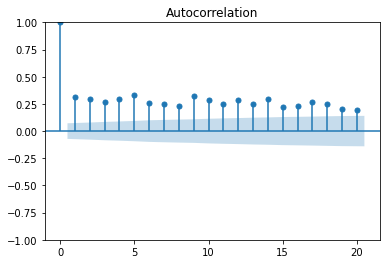

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


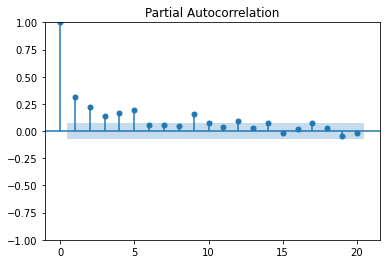

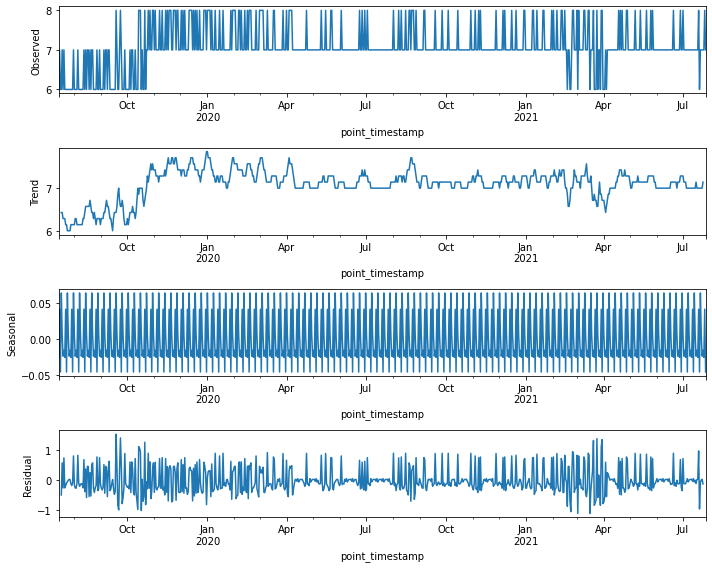

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2021-07-28    7.487009
2021-07-29    7.249831
2021-07-30    7.365339
2021-07-31    7.309086
2021-08-01    7.336481
                ...   
2023-08-07    7.316021
2023-08-08    7.316021
2023-08-09    7.316021
2023-08-10    7.316021
2023-08-11    7.316021
Freq: D, Name: predicted_mean, Length: 745, dtype: float64
SARIMA
(149,)
MAPE: 6.573040097426211


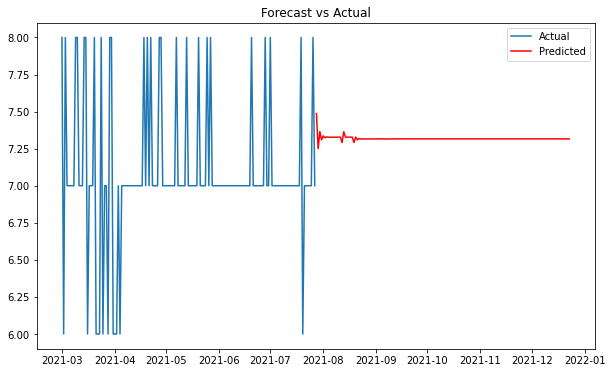

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('sample_1 (1).csv')

# Convert the timestamp to datetime format
data['point_timestamp'] = pd.to_datetime(data['point_timestamp'], format='%Y-%m-%d')
# Set 'point_timestamp' column as index
data.set_index('point_timestamp', inplace=True)

# Extract features
# Check stationarity using the ADF test
from statsmodels.tsa.stattools import adfuller
data['point_value'] = data['point_value'].interpolate(method='linear')
# Check for any remaining missing values
print(data.isnull().sum())
data = data.dropna()

# Check stationarity using the ADF test
result = adfuller(data['point_value'].interpolate(method='linear').dropna())
if result[1] > 0.05:
    # The series is non-stationary
    # Apply differencing
    diff_data = data['point_value'].diff().dropna()
    result = adfuller(diff_data)
    if result[1] > 0.05:
        print('Differenced series is still non-stationary.')
    else:
        print('Differenced series is stationary.')
else:
    # The series is already stationary
    print('The series is stationary.')


# Check autocorrelation using the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Extract the "point_value" column from the "data" DataFrame
point_value = data['point_value']

# Plot the autocorrelation function
plot_acf(point_value, lags=20)
plt.show()
plot_pacf(point_value, lags=20)
plt.show()

# Check seasonality using seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
result = seasonal_decompose(point_value, model='additive', period=7)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Define X_train, y_train, X_test, and y_test
X_train = train_data.drop('point_value', axis=1)
y_train = train_data['point_value']
X_test = test_data.drop('point_value', axis=1)
y_test = test_data['point_value']

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#print(data.index.min(), data.index.max())


# Train and evaluate different models based on the extracted features
# Seasonal ARIMA or SARIMA model
if result.seasonal is not None:
    model = SARIMAX(point_value, order=(1,1,0), seasonal_order=(1,0,0,24))
    results = model.fit()
    forecast = results.get_forecast(steps=len(point_value))
    forecast_ci = forecast.conf_int()
    forecast_mean = forecast.predicted_mean
    print(forecast_mean)
    print("SARIMA")


# XGBoost model
elif result.trend is not None:
    train_size = int(len(data) * 0.8)
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

    tscv = TimeSeriesSplit(n_splits=5)
    for fold, (train_index, test_index) in enumerate(tscv.split(data)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = data.iloc[train_index]['point_value'], data.iloc[test_index]['point_value']

    # Train XGBoost model
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model.fit(X_train, y_train)
    forecast_diff = model.predict(X_test )

    # Apply inverse differencing
    #forecast = scaler.inverse_transform(pd.DataFrame(forecast_diff, columns=['point_value'])).squeeze()

    print("XGBoost")
else:
    model = Prophet()
    data.reset_index(inplace=True)
    data.rename(columns={'point_timestamp':'ds', 'point_value':'y'}, inplace=True)
    model.fit(data)
    future = model.make_future_dataframe(periods=31, freq='D')
    forecast = model.predict(future)
    print("Prophet")

print(forecast)

# Calculate MAPE
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values
    """
    actual, predicted = np.array(actual), np.array(predicted)
    if np.isnan(actual).any() or np.isnan(predicted).any():
        return np.nan
    else:
        return np.mean(np.abs((actual - predicted) / actual)) * 100

print(y_test.shape)
#print(forecast.shape)


# Calculate MAPE for the model
forecast_mean = forecast.predicted_mean
y_test = y_test[-len(forecast_mean):]  # Use the same number of test data points as the length of forecast
forecast = forecast_mean[:len(y_test)] # Keep only the first len(y_test) elements of forecast
mape = calculate_mape(y_test, forecast)
print('MAPE:', mape)


# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(forecast.index, forecast, label='Predicted', color='red')
plt.legend()
plt.title('Forecast vs Actual')
plt.show()



